# DIAGNÓSTICO DE CÂNCER DE MAMA UTILIZANDO APRENDIZADO DE MÁQUINA

## Lucas Dias Pedrosa

<h3 align="center">Resumo</h3>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Algoritmos de aprendizado de máquina surgiram com a necessidade de automatizar a construção de modelos analíticos, identificando padrões e tomando decisões com o mínimo de interferência humana. Na área da medicina, possibilitou o auxílio em diagnósticos e o suporte à decisão clínica, ajudando profissionais e pacientes de diversas maneiras e melhorando a qualidade do atendimento clínico. O objetivo deste trabalho é desenvolver um sistema que utilize algoritmos de aprendizado de máquina para auxiliar o diagnóstico de um tumor, classificando-o como benigno ou maligno. O sistema deve utilizar um conjunto de dados de câncer de mama para o treinamento do modelo e realizar a classificação de um determinado tumor. Os resultados determinarão a acuracidade dos diferentes algoritmos de aprendizado de máquina na classificação dos tumores.

## 1) Importações

In [1]:
# pip install synapseclient lime shap xgboost termcolor

In [136]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import lime
import math
import seaborn as sns

import zipfile as zp
import synapseclient as syna
from getpass import getpass

from lime import lime_tabular

from termcolor import colored
from datetime import datetime
from numpy import interp

from sklearn.model_selection import KFold, train_test_split

from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2) Definição de funções

In [3]:
def plot_confusion_matrix(results, labels, image_name):
        
    sns.set(font_scale = 1.5)
    plt.figure(figsize=(10,8))
    threshold = 0.5
    index = 0
        
    for result in results:
                            
        cm = confusion_matrix(result.y_pred, result.y_test)
        ax = plt.subplot(2, 2, index+1)

        sns.set_palette("PuBuGn_d")
            
        sum_0 =  cm.sum(axis=1)[0]
        sum_1 = cm.sum(axis=1)[1]
        
        cm_aux = np.zeros((2,2))
        cm_aux[0][0] = (cm[1][1] / sum_1)
        cm_aux[0][1] = (cm[1][0] / sum_1)
        cm_aux[1][0] = (cm[0][1] / sum_0)
        cm_aux[1][1] = (cm[0][0] / sum_0)
        
        sns.heatmap(cm_aux, annot=True, ax = ax, fmt=".2%", cmap="Blues", cbar=False)
        
        ax.set_title(result.model_name)
        ax.yaxis.set_ticklabels(labels)
        ax.xaxis.set_ticklabels(labels)
        
        if index == 0 or index == 1:
            ax.set_xlabel('');
        else:
            ax.set_xlabel('Classe prevista');
            
        if index == 1 or index == 3:
            ax.set_ylabel(''); 
        else:
            ax.set_ylabel('Classe real')
            
        index = index + 1
        
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + image_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.4)
    plt.show()

In [4]:
def plot_roc_curve(results, file_name):
        
    plt.figure(figsize=(10,8))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 0
    
    colors = ['r','b','g', 'm']
    
    for idx,result in enumerate(results):
    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_tpr = np.mean(result.tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_auc = np.std(result.aucs)
        avg_auc = metrics.roc_auc_score(pd.factorize(result.y_test)[0], pd.factorize(result.y_pred)[0])
        
        plt.plot(mean_fpr, mean_tpr, color=colors[idx],
                 label=result.model_name + ' (AUC = %0.3f $\pm$ %0.3f)' % (avg_auc, std_auc), lw=2, alpha=0.8)
        
        std_tpr = np.std(result.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        if i == 0:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        else:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        i = i + 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', size=15)
    plt.ylabel('Taxa de Verdadeiros Positivos', size=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.title('CURVA ROC')    
    
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + file_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [5]:
def generate_performance_stats(y_test, y_pred): 
    target_names = ['Benigno', 'Maligno'] 
    cm = confusion_matrix(y_test, y_pred)
    print("Acurácia: {}\n".format(metrics.accuracy_score(y_test,y_pred)))
    print("Auc: {}\n".format(metrics.roc_auc_score(pd.factorize(y_test)[0],pd.factorize(y_pred)[0])))
    print("Matriz de confusão: \n{}\n".format(pd.crosstab(y_test, y_pred, rownames=['Atual'], colnames=['Previsto'])))
    print("Relatório de Classificação: \n{}\n".format(classification_report(y_test, y_pred, target_names=target_names)))

In [6]:
def evaluate_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """
    Used to evaluate a given model. Just an API wrapper.    
    Returns the fitted model along with the predictions generated for the test set
    """
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)
    return model, y_preds, y_preds_proba

In [7]:
def perform_cv(df_train, models, n_folds, use_oversampling=False):
        
    results = []
    mean_fpr = np.linspace(0, 1, 100)
    models_predictions = {}

    for model_alias in models:
    
        print("Modelo: {}\n".format(model_alias))
        y_preds = []
        y_probs = []
        y_tests = []
        tprs = []
        aucs = []
        thresholds = []
        model = models[model_alias]

        i = 0
        kf = KFold(n_splits=n_folds, random_state=13, shuffle=True)
    
        for index in kf.split(df_train):

            print("Fold[{}]\n".format(i+1))

            X_train, X_test = df_train.iloc[index[0]], df_train.iloc[index[1]]
                     
            y_train = X_train['diagnostico']
            X_train = X_train.drop(['diagnostico'], axis = 1)
                     
            y_test = X_test['diagnostico']
            X_test = X_test.drop(['diagnostico'], axis = 1)
            
            model_fit, y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)

            fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1], pos_label='M')
            prec, rec, tre = precision_recall_curve(y_test, y_pred_proba[:,1], pos_label='M')
            
            y_preds = np.append(y_preds, y_pred)
            y_probs = np.append(y_probs, y_pred_proba[:,1])
            y_tests = np.append(y_tests, y_test)        
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            thresholds.append(threshold)
            i = i + 1
    
        generate_performance_stats(y_preds, y_tests)

        result = RESULT(model_alias, y_preds, y_probs, y_tests, tprs, aucs, thresholds)
        results.append(result)
        models_predictions[model_alias] = (y_preds, y_tests)
        print("########################################################\n")
    
    return results, models_predictions

In [8]:
def plot_violin(df: pd.DataFrame, start, end, fig_name):
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    data = X
    data_normal = (data - data.mean()) / (data.std())
    
    data = pd.concat([y, data_normal.iloc[:, start:end]], axis=1)
    data = pd.melt(data, id_vars='diagnostico', var_name='variaveis', value_name='valores')
    plt.figure(figsize=(10, 10))
    sns.violinplot(x='variaveis', y='valores', hue='diagnostico', data=data, split=True, inner='quart', palette=('r', 'g'))
    plt.xticks(rotation=45)
    plt.savefig('./imgs/Analise/' + fig_name, bbox_inches='tight')

In [9]:
def plot_joint(df: pd.DataFrame, feature1, feature2, fig_name):
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    
    plt.figure(figsize=(10, 10))
    sns.jointplot(x=feature1, y=feature2, data=df, kind='kde', hue='diagnostico', palette=('r', 'g'), fill=True, joint_kws={'alpha': 0.7})
    plt.savefig('./imgs/Analise/' + fig_name, bbox_inches='tight')

In [10]:
def plot_swarm(df: pd.DataFrame, start, end, fig_name):
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    data = X
    data_normal = (data - data.mean()) / (data.std())
    
    data = pd.concat([y, data_normal.iloc[:, start:end]], axis=1)
    data = pd.melt(data, id_vars="diagnostico", var_name="variaveis", value_name='valores')
    plt.figure(figsize=(10,10))
    sns.swarmplot(x="variaveis", y="valores", hue="diagnostico", data=data, s=3, palette=('r', 'g'))
    plt.xticks(rotation=90)
    plt.savefig('./imgs/Analise/' + fig_name, bbox_inches='tight')

## 3) Carregamento dos dados

Base de dados: http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29

In [11]:
df = pd.read_csv('main_data.csv')

df.drop('id', axis=1, inplace=True)
df.drop('Unnamed: 32', axis=1, inplace=True)

In [12]:
df.rename(columns={'diagnosis': 'diagnostico',
                   'radius_mean': 'raio_media',
                   'texture_mean': 'textura_media',
                   'perimeter_mean': 'perimetro_media',
                   'area_mean': 'area_media',
                   'smoothness_mean': 'suavidade_media',
                   'compactness_mean': 'compacidade_media',
                   'concavity_mean': 'concavidade_media',
                   'concave points_mean': 'pontos_concavos_media',
                   'symmetry_mean': 'simetria_media',
                   'fractal_dimension_mean': 'dimensao_fractal_media',
                   'radius_se': 'raio_ep',
                   'texture_se': 'textura_ep',
                   'perimeter_se': 'perimetro_ep',
                   'area_se': 'area_ep',
                   'smoothness_se': 'suavidade_ep',
                   'compactness_se': 'compacidade_ep',
                   'concavity_se': 'concavidade_ep',
                   'concave points_se': 'pontos_concavos_ep',
                   'symmetry_se': 'simetria_ep',
                   'fractal_dimension_se': 'dimensao_fractal_ep',
                   'radius_worst': 'raio_maior',
                   'texture_worst': 'textura_maior',
                   'perimeter_worst': 'perimetro_maior',
                   'area_worst': 'area_maior',
                   'smoothness_worst': 'suavidade_maior',
                   'compactness_worst': 'compacidade_maior',
                   'concavity_worst': 'concavidade_maior',
                   'concave points_worst': 'pontos_concavos_maior',
                   'symmetry_worst': 'simetria_maior',
                   'fractal_dimension_worst': 'dimensao_fractal_maior'}, inplace=True)

In [13]:
df.dtypes

diagnostico                object
raio_media                float64
textura_media             float64
perimetro_media           float64
area_media                float64
suavidade_media           float64
compacidade_media         float64
concavidade_media         float64
pontos_concavos_media     float64
simetria_media            float64
dimensao_fractal_media    float64
raio_ep                   float64
textura_ep                float64
perimetro_ep              float64
area_ep                   float64
suavidade_ep              float64
compacidade_ep            float64
concavidade_ep            float64
pontos_concavos_ep        float64
simetria_ep               float64
dimensao_fractal_ep       float64
raio_maior                float64
textura_maior             float64
perimetro_maior           float64
area_maior                float64
suavidade_maior           float64
compacidade_maior         float64
concavidade_maior         float64
pontos_concavos_maior     float64
simetria_maior

In [14]:
df.shape

(569, 31)

In [15]:
df.head()

diagnostico  raio_media  textura_media  perimetro_media  area_media  \
0           M       17.99          10.38           122.80      1001.0   
1           M       20.57          17.77           132.90      1326.0   
2           M       19.69          21.25           130.00      1203.0   
3           M       11.42          20.38            77.58       386.1   
4           M       20.29          14.34           135.10      1297.0   

   suavidade_media  compacidade_media  concavidade_media  \
0          0.11840            0.27760             0.3001   
1          0.08474            0.07864             0.0869   
2          0.10960            0.15990             0.1974   
3          0.14250            0.28390             0.2414   
4          0.10030            0.13280             0.1980   

   pontos_concavos_media  simetria_media  ...  raio_maior  textura_maior  \
0                0.14710          0.2419  ...       25.38          17.33   
1                0.07017          0.1812  ...       24.99          23.41   
2                0.12790          0.2069  ...       23.57          25.53   
3                0.10520          0.2597  ...       14.91          26.50   
4                0.10430          0.1809  ...       22.54          16.67   

   perimetro_maior  area_maior  suavidade_maior  compacidade_maior  \
0           184.60      2019.0           0.1622             0.6656   
1           158.80      1956.0           0.1238             0.1866   
2           152.50      1709.0           0.1444             0.4245   
3            98.87       567.7           0.2098             0.8663   
4           152.20      1575.0           0.1374             0.2050   

   concavidade_maior  pontos_concavos_maior  simetria_maior  \
0             0.7119                 0.2654          0.4601   
1             0.2416                 0.1860          0.2750   
2             0.4504                 0.2430          0.3613   
3             0.6869                 0.2575          0.6638   
4             0.4000                 0.1625          0.2364   

   dimensao_fractal_maior  
0                 0.11890  
1                 0.08902  
2                 0.08758  
3                 0.17300  
4                 0.07678  

[5 rows x 31 columns]

<h6>Número de NaN por coluna</h6>

In [16]:
nan_df = pd.DataFrame(df.isna().sum().tolist(), df.columns.tolist()).reset_index()
nan_df.columns = ['Nome da Coluna', 'total_nan']
nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df),3)
nan_df = nan_df.sort_values('total_nan', ascending=False)
nan_df

Nome da Coluna  total_nan  nan_perc
0              diagnostico          0       0.0
16          compacidade_ep          0       0.0
29          simetria_maior          0       0.0
28   pontos_concavos_maior          0       0.0
27       concavidade_maior          0       0.0
26       compacidade_maior          0       0.0
25         suavidade_maior          0       0.0
24              area_maior          0       0.0
23         perimetro_maior          0       0.0
22           textura_maior          0       0.0
21              raio_maior          0       0.0
20     dimensao_fractal_ep          0       0.0
19             simetria_ep          0       0.0
18      pontos_concavos_ep          0       0.0
17          concavidade_ep          0       0.0
15            suavidade_ep          0       0.0
1               raio_media          0       0.0
14                 area_ep          0       0.0
13            perimetro_ep          0       0.0
12              textura_ep          0       0.0
11                 raio_ep          0       0.0
10  dimensao_fractal_media          0       0.0
9           simetria_media          0       0.0
8    pontos_concavos_media          0       0.0
7        concavidade_media          0       0.0
6        compacidade_media          0       0.0
5          suavidade_media          0       0.0
4               area_media          0       0.0
3          perimetro_media          0       0.0
2            textura_media          0       0.0
30  dimensao_fractal_maior          0       0.0

<h6>Número de null por coluna</h6>

In [17]:
null_df = pd.DataFrame(df.isnull().sum().tolist(), df.columns.tolist()).reset_index()
null_df.columns = ['Nome da coluna', 'total_null']
null_df['null_perc'] = 100*round(null_df['total_null']/len(df),3)
null_df = null_df.sort_values('total_null', ascending=False)
null_df

Nome da coluna  total_null  null_perc
0              diagnostico           0        0.0
16          compacidade_ep           0        0.0
29          simetria_maior           0        0.0
28   pontos_concavos_maior           0        0.0
27       concavidade_maior           0        0.0
26       compacidade_maior           0        0.0
25         suavidade_maior           0        0.0
24              area_maior           0        0.0
23         perimetro_maior           0        0.0
22           textura_maior           0        0.0
21              raio_maior           0        0.0
20     dimensao_fractal_ep           0        0.0
19             simetria_ep           0        0.0
18      pontos_concavos_ep           0        0.0
17          concavidade_ep           0        0.0
15            suavidade_ep           0        0.0
1               raio_media           0        0.0
14                 area_ep           0        0.0
13            perimetro_ep           0        0.0
12              textura_ep           0        0.0
11                 raio_ep           0        0.0
10  dimensao_fractal_media           0        0.0
9           simetria_media           0        0.0
8    pontos_concavos_media           0        0.0
7        concavidade_media           0        0.0
6        compacidade_media           0        0.0
5          suavidade_media           0        0.0
4               area_media           0        0.0
3          perimetro_media           0        0.0
2            textura_media           0        0.0
30  dimensao_fractal_maior           0        0.0

## 4) Análise exploratória dos dados

In [18]:
df.describe()

raio_media  textura_media  perimetro_media   area_media  \
count  569.000000     569.000000       569.000000   569.000000   
mean    14.127292      19.289649        91.969033   654.889104   
std      3.524049       4.301036        24.298981   351.914129   
min      6.981000       9.710000        43.790000   143.500000   
25%     11.700000      16.170000        75.170000   420.300000   
50%     13.370000      18.840000        86.240000   551.100000   
75%     15.780000      21.800000       104.100000   782.700000   
max     28.110000      39.280000       188.500000  2501.000000   

       suavidade_media  compacidade_media  concavidade_media  \
count       569.000000         569.000000         569.000000   
mean          0.096360           0.104341           0.088799   
std           0.014064           0.052813           0.079720   
min           0.052630           0.019380           0.000000   
25%           0.086370           0.064920           0.029560   
50%           0.095870           0.092630           0.061540   
75%           0.105300           0.130400           0.130700   
max           0.163400           0.345400           0.426800   

       pontos_concavos_media  simetria_media  dimensao_fractal_media  ...  \
count             569.000000      569.000000              569.000000  ...   
mean                0.048919        0.181162                0.062798  ...   
std                 0.038803        0.027414                0.007060  ...   
min                 0.000000        0.106000                0.049960  ...   
25%                 0.020310        0.161900                0.057700  ...   
50%                 0.033500        0.179200                0.061540  ...   
75%                 0.074000        0.195700                0.066120  ...   
max                 0.201200        0.304000                0.097440  ...   

       raio_maior  textura_maior  perimetro_maior   area_maior  \
count  569.000000     569.000000       569.000000   569.000000   
mean    16.269190      25.677223       107.261213   880.583128   
std      4.833242       6.146258        33.602542   569.356993   
min      7.930000      12.020000        50.410000   185.200000   
25%     13.010000      21.080000        84.110000   515.300000   
50%     14.970000      25.410000        97.660000   686.500000   
75%     18.790000      29.720000       125.400000  1084.000000   
max     36.040000      49.540000       251.200000  4254.000000   

       suavidade_maior  compacidade_maior  concavidade_maior  \
count       569.000000         569.000000         569.000000   
mean          0.132369           0.254265           0.272188   
std           0.022832           0.157336           0.208624   
min           0.071170           0.027290           0.000000   
25%           0.116600           0.147200           0.114500   
50%           0.131300           0.211900           0.226700   
75%           0.146000           0.339100           0.382900   
max           0.222600           1.058000           1.252000   

       pontos_concavos_maior  simetria_maior  dimensao_fractal_maior  
count             569.000000      569.000000              569.000000  
mean                0.114606        0.290076                0.083946  
std                 0.065732        0.061867                0.018061  
min                 0.000000        0.156500                0.055040  
25%                 0.064930        0.250400                0.071460  
50%                 0.099930        0.282200                0.080040  
75%                 0.161400        0.317900                0.092080  
max                 0.291000        0.663800                0.207500  

[8 rows x 30 columns]

<h6>1) Distribuição dos dados</h6>

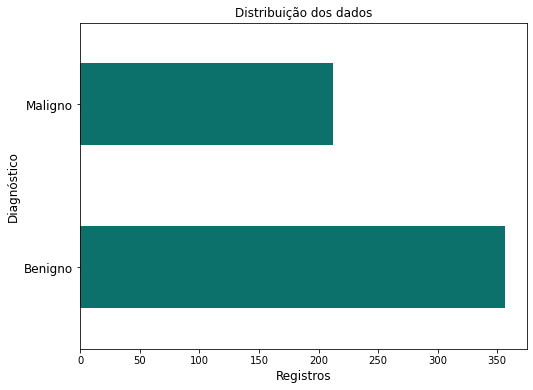

Benigno    357
Maligno    212
Name: diagnostico, dtype: int64


In [19]:
diagnostico_counts = df['diagnostico'].replace(['M', 'B'], ['Maligno', 'Benigno']).value_counts()

plt.figure(figsize=(8,6))
plt.title('Distribuição dos dados')
diagnostico_counts.plot(kind='barh', color='#0c706b')
plt.yticks(size=12)
plt.xlabel('Registros', size=12)
plt.ylabel('Diagnóstico', size=12)

plt.savefig('./imgs/Analise/distribuicao_dados.png', bbox_inches='tight')
plt.show()
print(diagnostico_counts)

<h6>2) Histograma das variáves</h6>

<Figure size 432x288 with 0 Axes>

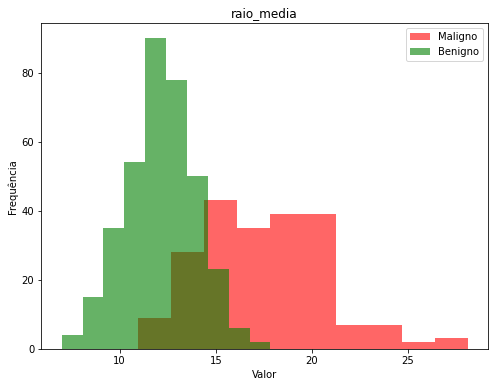

<Figure size 432x288 with 0 Axes>

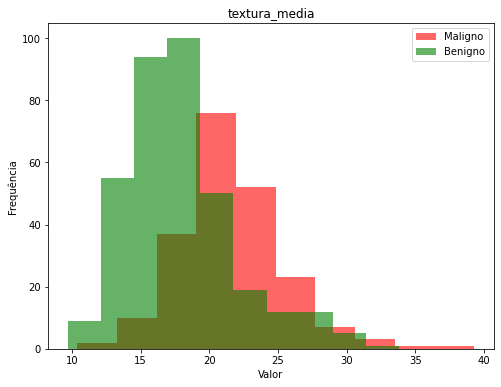

<Figure size 432x288 with 0 Axes>

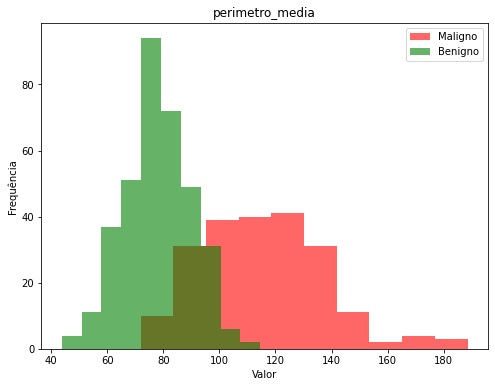

<Figure size 432x288 with 0 Axes>

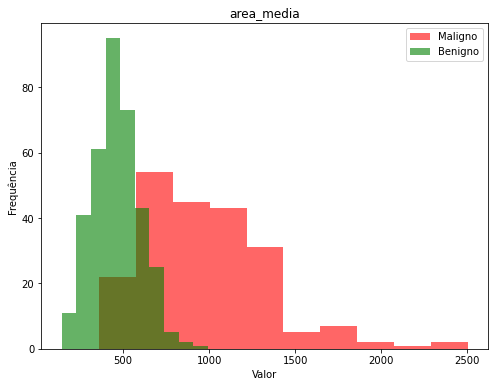

<Figure size 432x288 with 0 Axes>

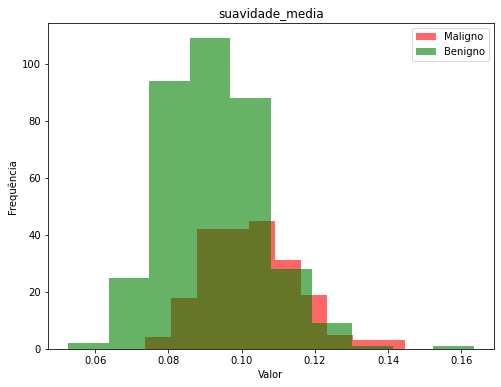

<Figure size 432x288 with 0 Axes>

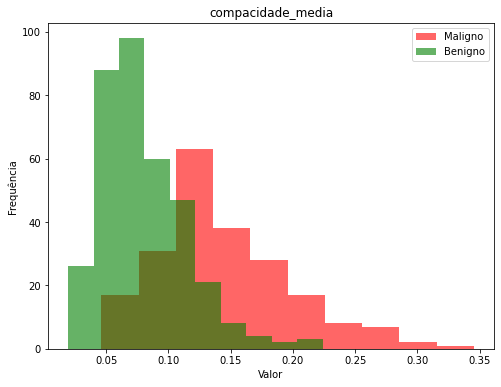

<Figure size 432x288 with 0 Axes>

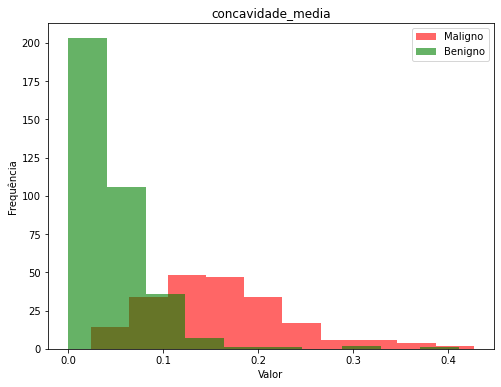

<Figure size 432x288 with 0 Axes>

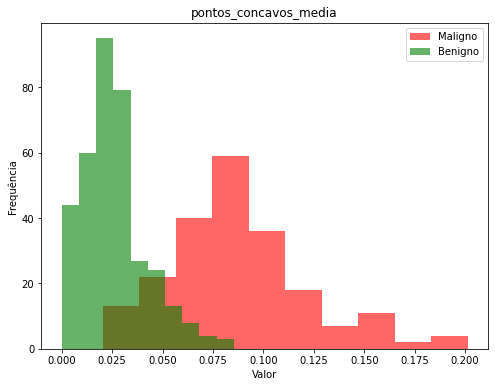

<Figure size 432x288 with 0 Axes>

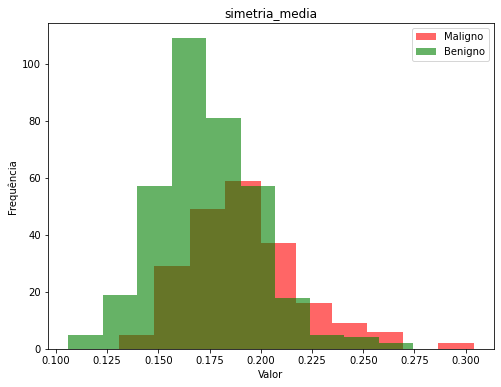

<Figure size 432x288 with 0 Axes>

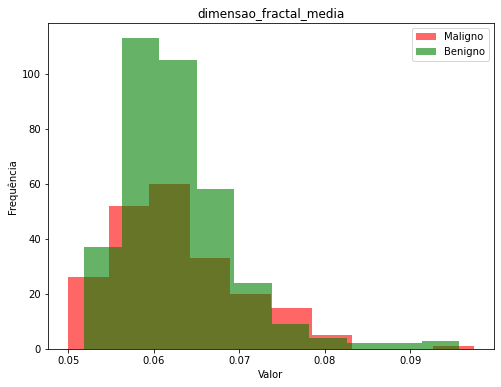

<Figure size 432x288 with 0 Axes>

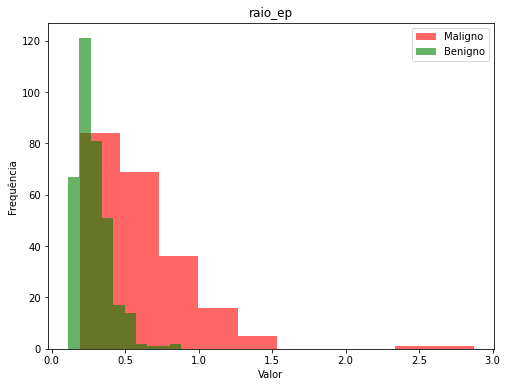

<Figure size 432x288 with 0 Axes>

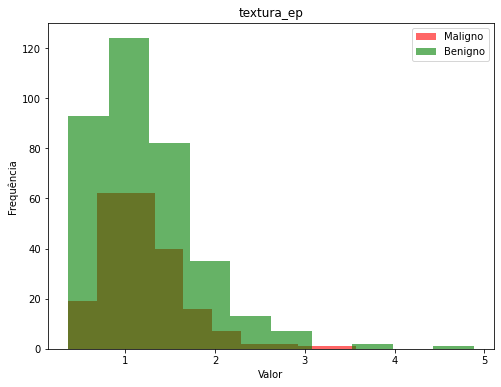

<Figure size 432x288 with 0 Axes>

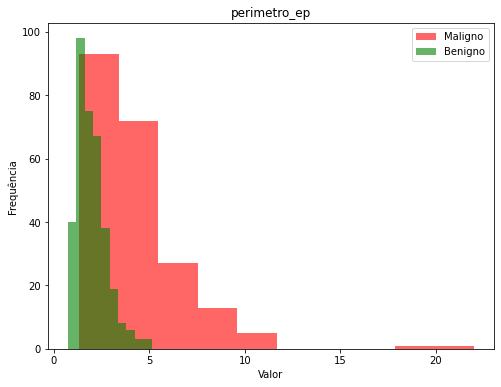

<Figure size 432x288 with 0 Axes>

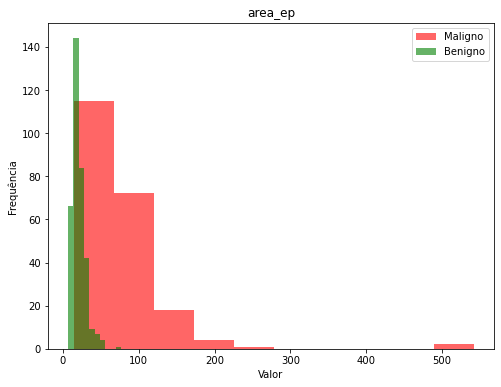

<Figure size 432x288 with 0 Axes>

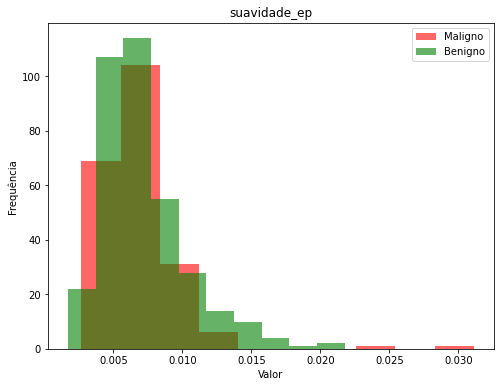

<Figure size 432x288 with 0 Axes>

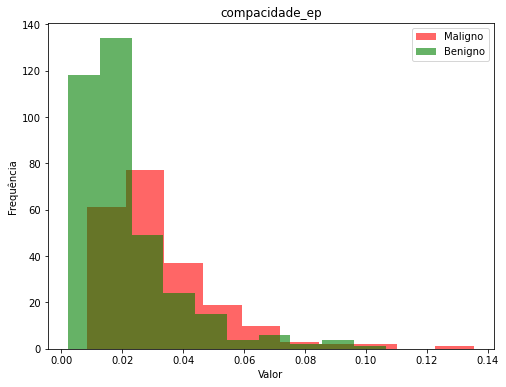

<Figure size 432x288 with 0 Axes>

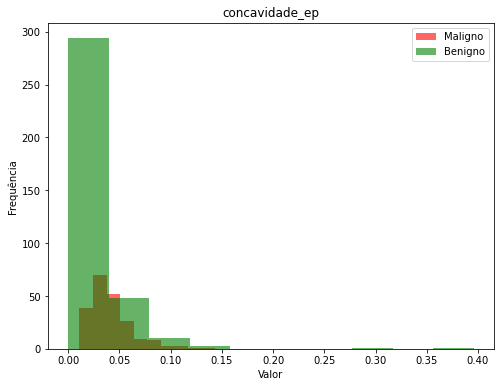

<Figure size 432x288 with 0 Axes>

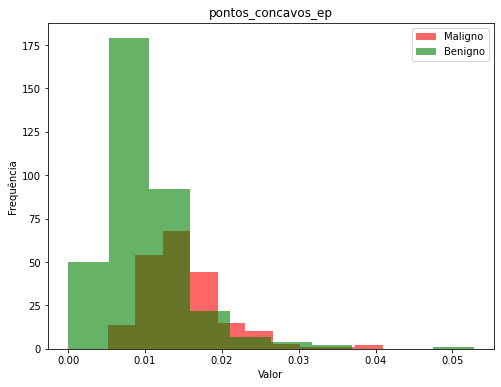

<Figure size 432x288 with 0 Axes>

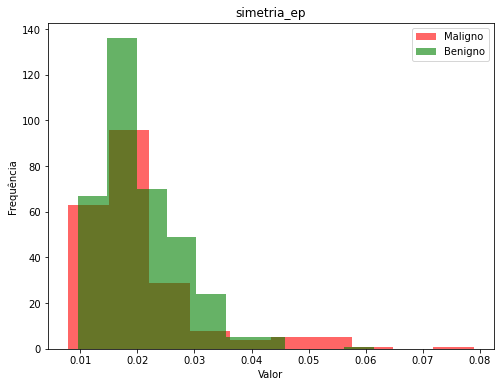

<Figure size 432x288 with 0 Axes>

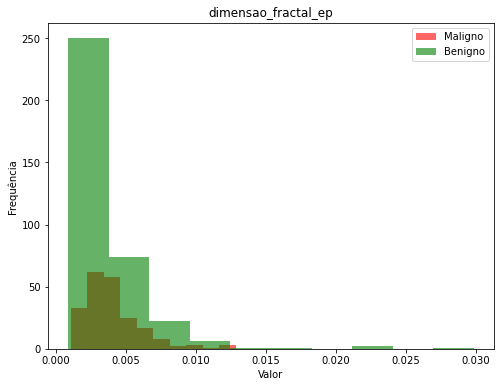

<Figure size 432x288 with 0 Axes>

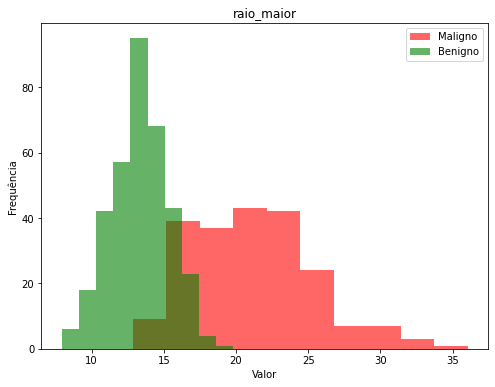

<Figure size 432x288 with 0 Axes>

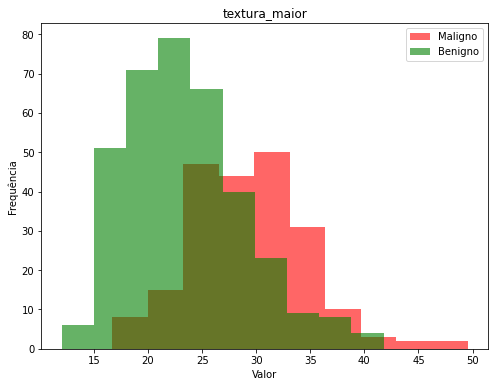

<Figure size 432x288 with 0 Axes>

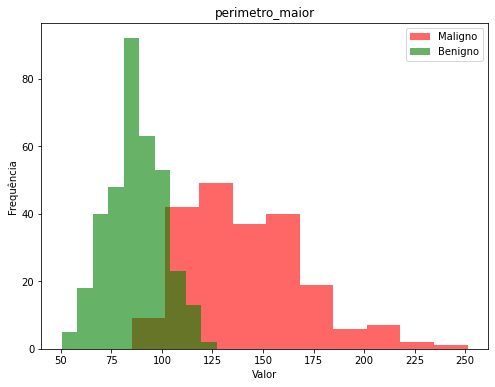

<Figure size 432x288 with 0 Axes>

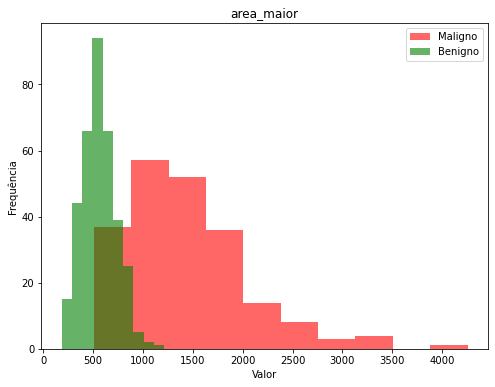

<Figure size 432x288 with 0 Axes>

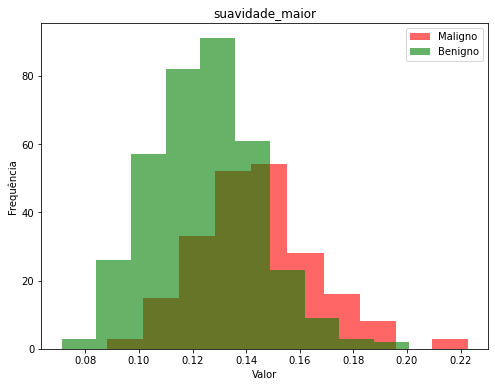

<Figure size 432x288 with 0 Axes>

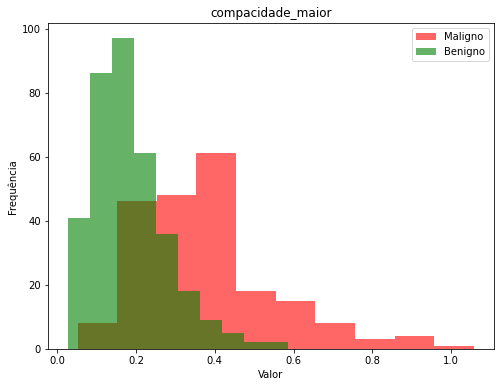

<Figure size 432x288 with 0 Axes>

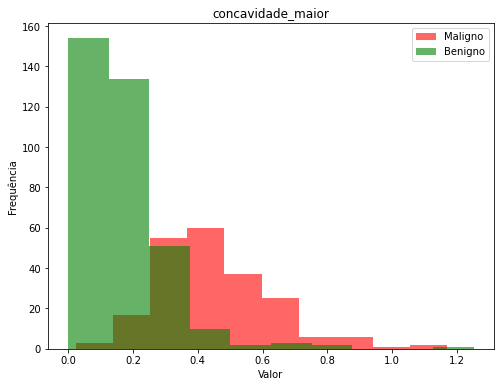

<Figure size 432x288 with 0 Axes>

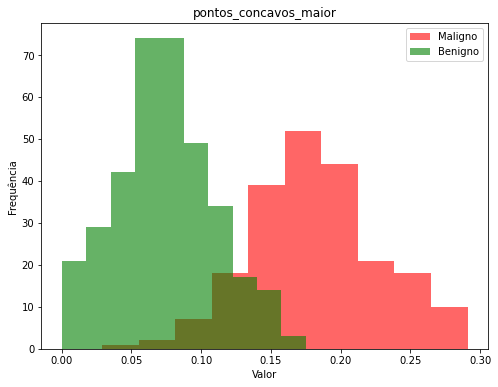

<Figure size 432x288 with 0 Axes>

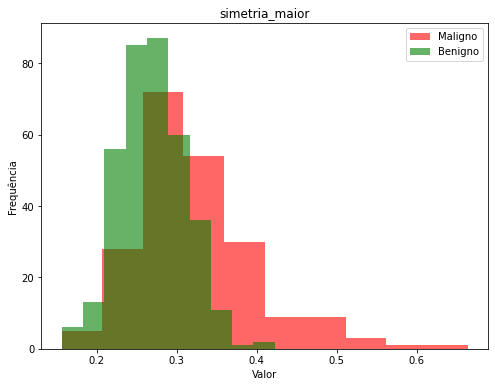

<Figure size 432x288 with 0 Axes>

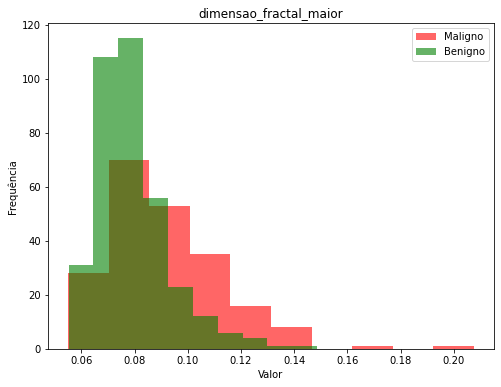

In [20]:
box = df.drop('diagnostico', axis=1)
for name, values in box.iteritems():
    plt.figure()
    plt.figure(figsize=(8,6))
    df[name][df['diagnostico'] == 'M'].plot.hist(alpha=0.6, color='red', label='Maligno', title=name)
    df[name][df['diagnostico'] == 'B'].plot.hist(alpha=0.6, color='green', label='Benigno')
    plt.ylabel('Frequência')
    plt.xlabel('Valor')
    plt.legend(loc='upper right')
    plt.show()

<h6>3) Diagrama de pares</h6>

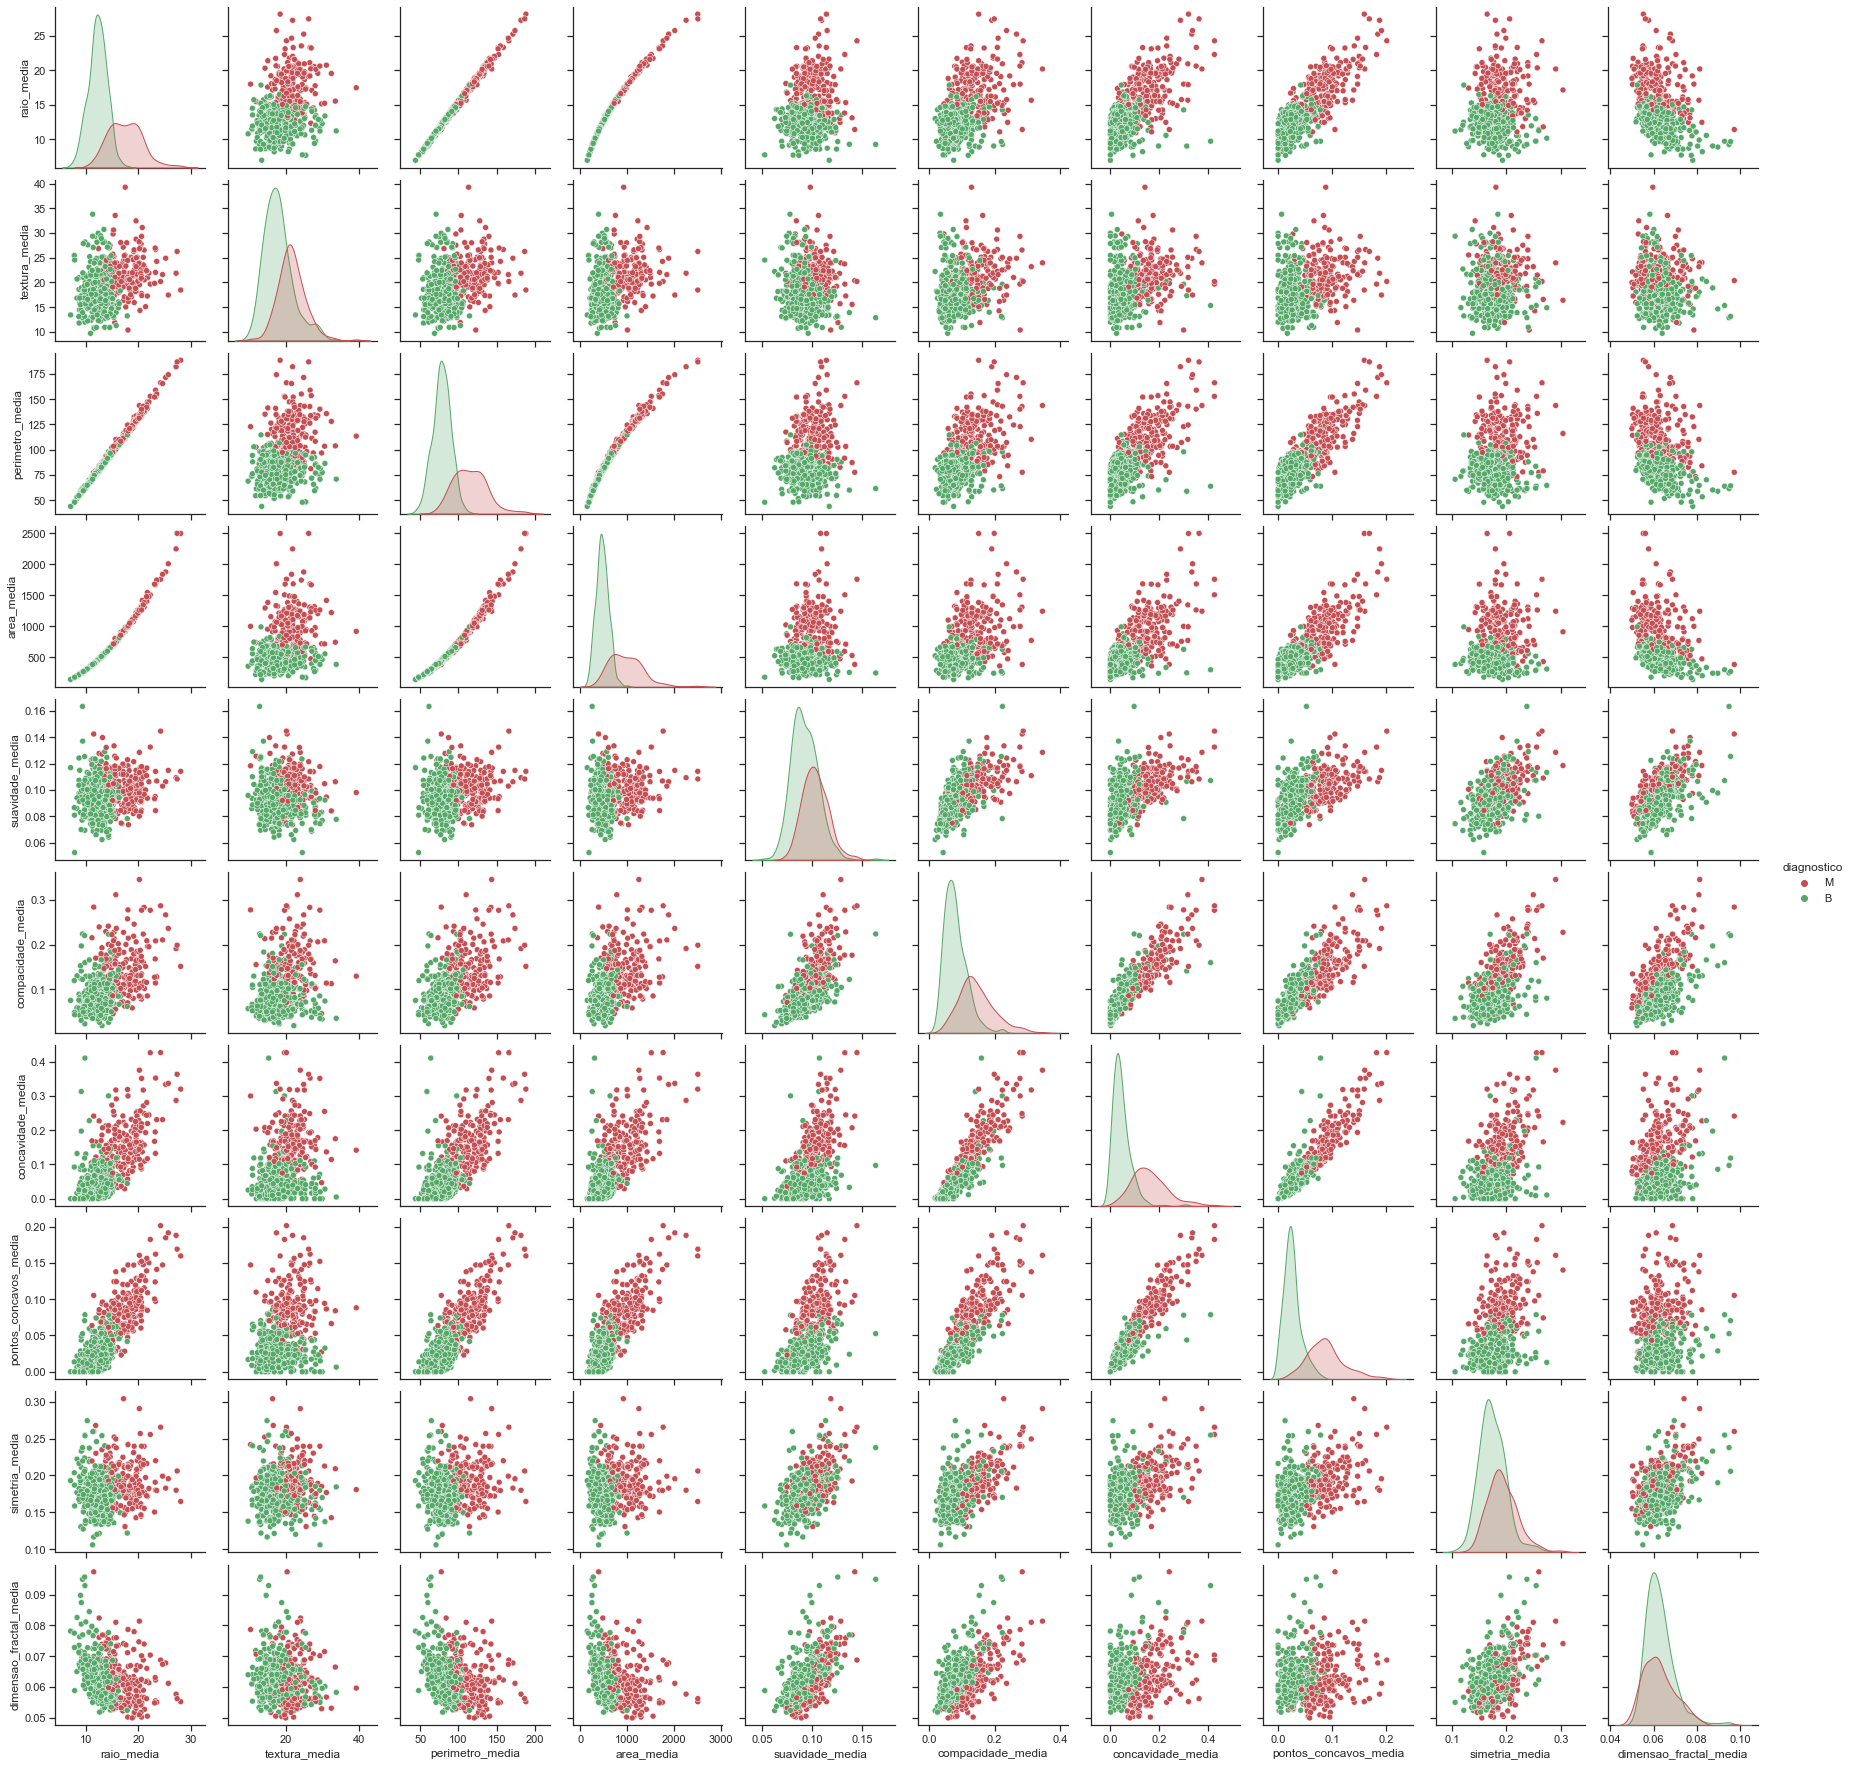

In [21]:
df_media = df.drop(df.iloc[:, 11:32], axis=1)

sns.set(style='ticks')
sns.pairplot(df_media, palette=('r', 'g'), hue='diagnostico')
plt.show()

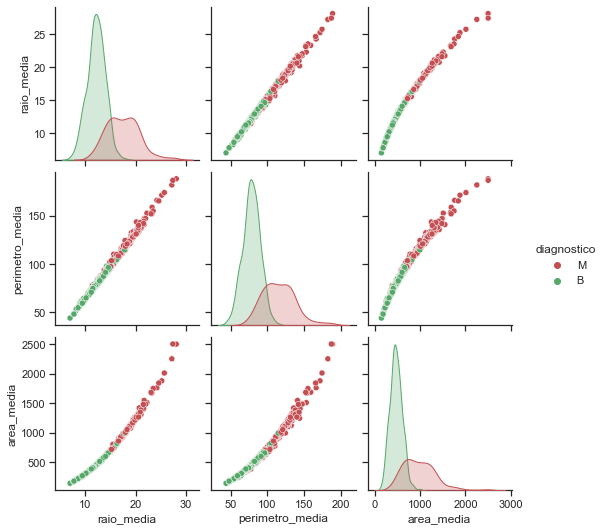

In [22]:
sns.set(style='ticks')
sns.pairplot(df_media[['diagnostico', 'raio_media', 'perimetro_media', 'area_media']], palette=('r', 'g'), hue='diagnostico')
plt.show()

<h6>4) Correlação das variáveis</h6>

In [23]:
df.corr()

raio_media  textura_media  perimetro_media  \
raio_media                1.000000       0.323782         0.997855   
textura_media             0.323782       1.000000         0.329533   
perimetro_media           0.997855       0.329533         1.000000   
area_media                0.987357       0.321086         0.986507   
suavidade_media           0.170581      -0.023389         0.207278   
compacidade_media         0.506124       0.236702         0.556936   
concavidade_media         0.676764       0.302418         0.716136   
pontos_concavos_media     0.822529       0.293464         0.850977   
simetria_media            0.147741       0.071401         0.183027   
dimensao_fractal_media   -0.311631      -0.076437        -0.261477   
raio_ep                   0.679090       0.275869         0.691765   
textura_ep               -0.097317       0.386358        -0.086761   
perimetro_ep              0.674172       0.281673         0.693135   
area_ep                   0.735864       0.259845         0.744983   
suavidade_ep             -0.222600       0.006614        -0.202694   
compacidade_ep            0.206000       0.191975         0.250744   
concavidade_ep            0.194204       0.143293         0.228082   
pontos_concavos_ep        0.376169       0.163851         0.407217   
simetria_ep              -0.104321       0.009127        -0.081629   
dimensao_fractal_ep      -0.042641       0.054458        -0.005523   
raio_maior                0.969539       0.352573         0.969476   
textura_maior             0.297008       0.912045         0.303038   
perimetro_maior           0.965137       0.358040         0.970387   
area_maior                0.941082       0.343546         0.941550   
suavidade_maior           0.119616       0.077503         0.150549   
compacidade_maior         0.413463       0.277830         0.455774   
concavidade_maior         0.526911       0.301025         0.563879   
pontos_concavos_maior     0.744214       0.295316         0.771241   
simetria_maior            0.163953       0.105008         0.189115   
dimensao_fractal_maior    0.007066       0.119205         0.051019   

                        area_media  suavidade_media  compacidade_media  \
raio_media                0.987357         0.170581           0.506124   
textura_media             0.321086        -0.023389           0.236702   
perimetro_media           0.986507         0.207278           0.556936   
area_media                1.000000         0.177028           0.498502   
suavidade_media           0.177028         1.000000           0.659123   
compacidade_media         0.498502         0.659123           1.000000   
concavidade_media         0.685983         0.521984           0.883121   
pontos_concavos_media     0.823269         0.553695           0.831135   
simetria_media            0.151293         0.557775           0.602641   
dimensao_fractal_media   -0.283110         0.584792           0.565369   
raio_ep                   0.732562         0.301467           0.497473   
textura_ep               -0.066280         0.068406           0.046205   
perimetro_ep              0.726628         0.296092           0.548905   
area_ep                   0.800086         0.246552           0.455653   
suavidade_ep             -0.166777         0.332375           0.135299   
compacidade_ep            0.212583         0.318943           0.738722   
concavidade_ep            0.207660         0.248396           0.570517   
pontos_concavos_ep        0.372320         0.380676           0.642262   
simetria_ep              -0.072497         0.200774           0.229977   
dimensao_fractal_ep      -0.019887         0.283607           0.507318   
raio_maior                0.962746         0.213120           0.535315   
textura_maior             0.287489         0.036072           0.248133   
perimetro_maior           0.959120         0.238853           0.590210   
area_maior                0.959213         0.206718           0.509604   
sua

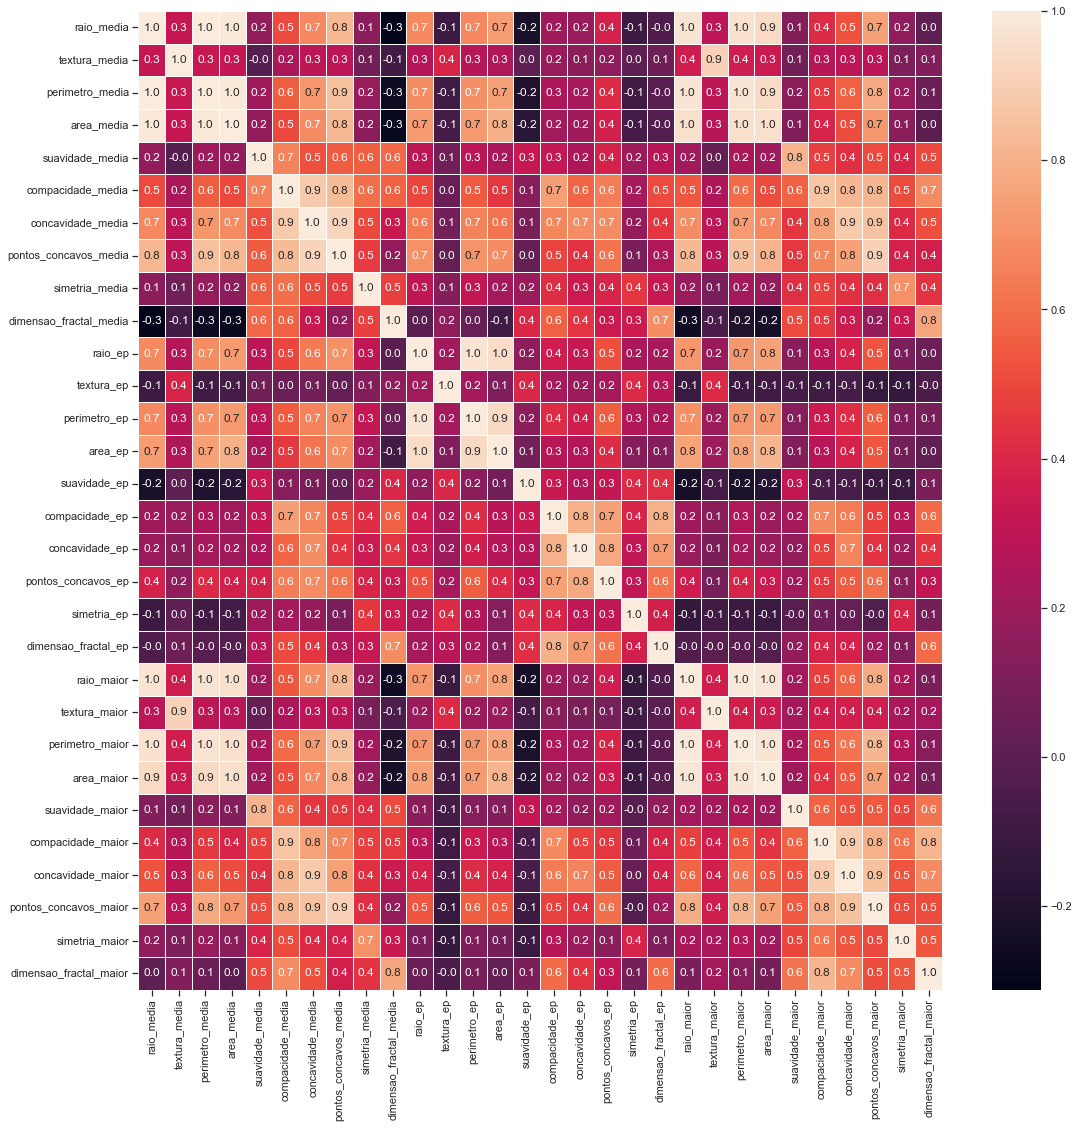

In [24]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

plt.savefig('./imgs/Analise/correlacao_dados.png', bbox_inches='tight')

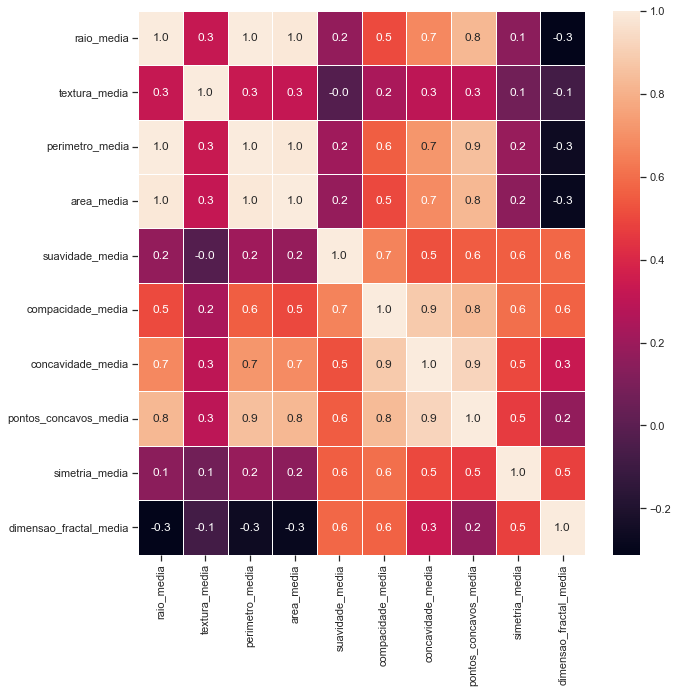

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.iloc[:, 0:11].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

plt.savefig('./imgs/Analise/correlacao_dados_media.png', bbox_inches='tight')

<h6>5) Gráfico de violino</h6>

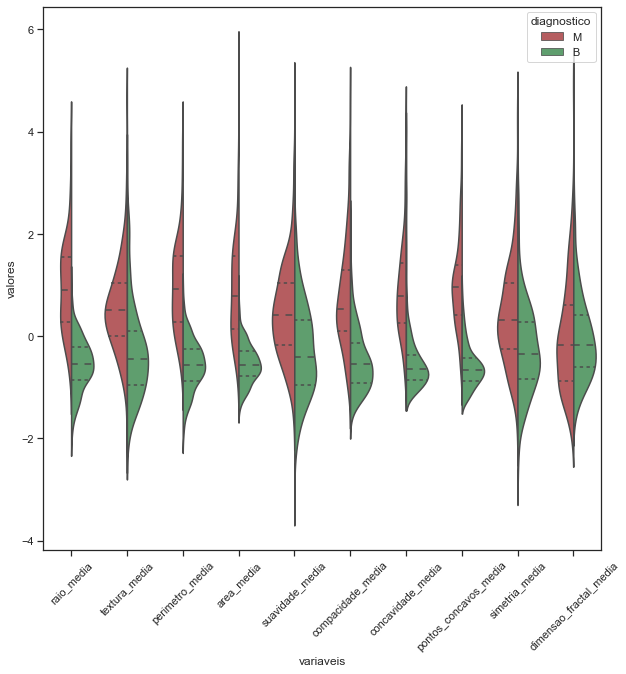

In [26]:
plot_violin(df, 0, 10, 'violino_media')

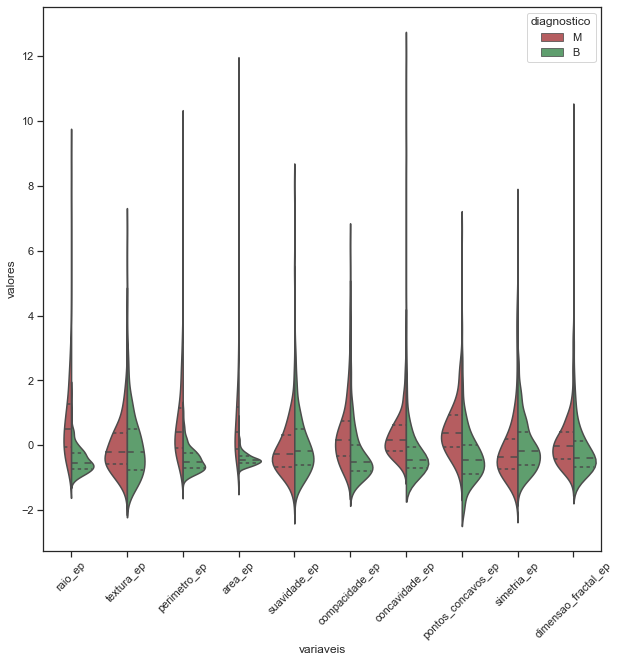

In [27]:
plot_violin(df, 10, 20, 'violino_ep')

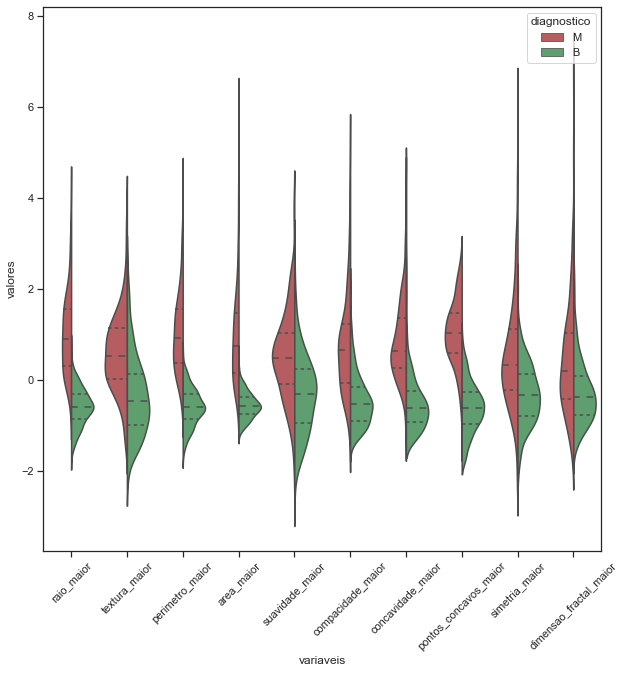

In [28]:
plot_violin(df, 20, 31, 'violino_maior')

<h6>6) Analisando variáveis com forte correlação com Joint Plot</h6>

<Figure size 720x720 with 0 Axes>

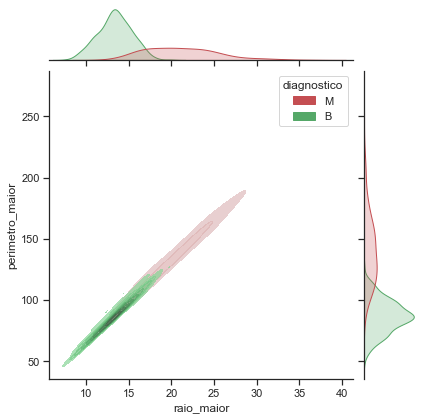

In [29]:
plot_joint(df, 'raio_maior', 'perimetro_maior', 'joint_raiomaior_perimetromaior')

<h6>Analisando separação das classes com Swarm plot</h6>

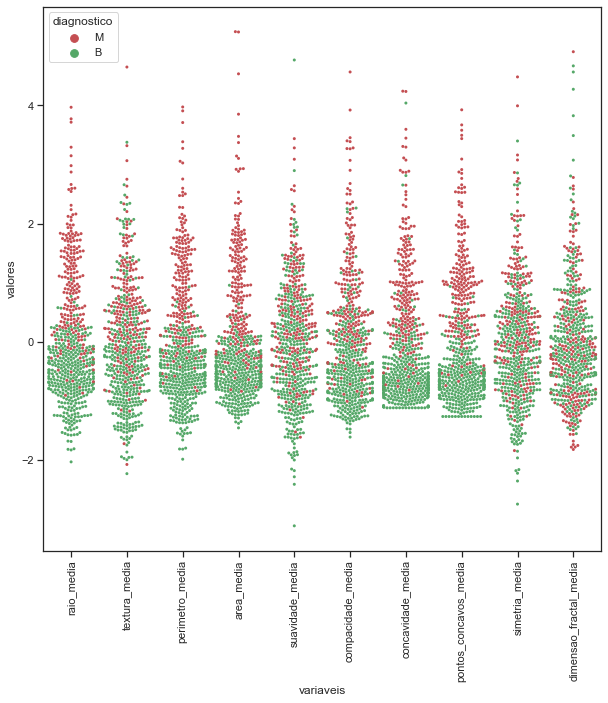

In [30]:
plot_swarm(df, 0, 10, 'swarm_media')

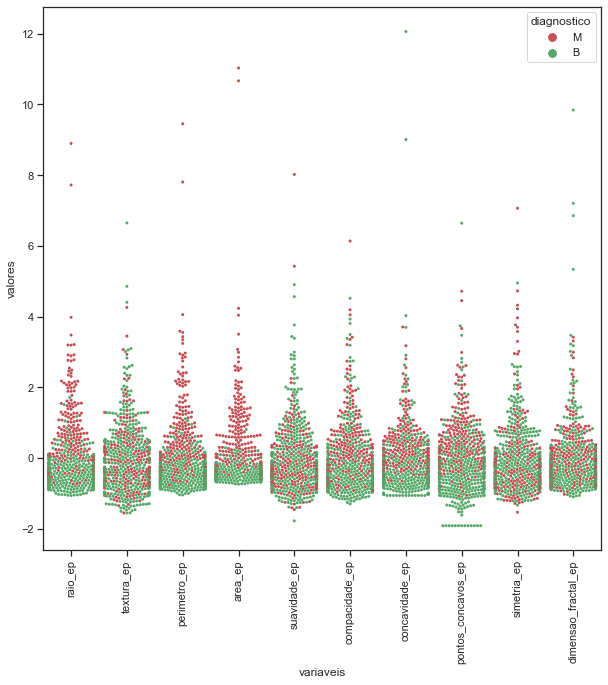

In [31]:
plot_swarm(df, 10, 20, 'swarm_ep')

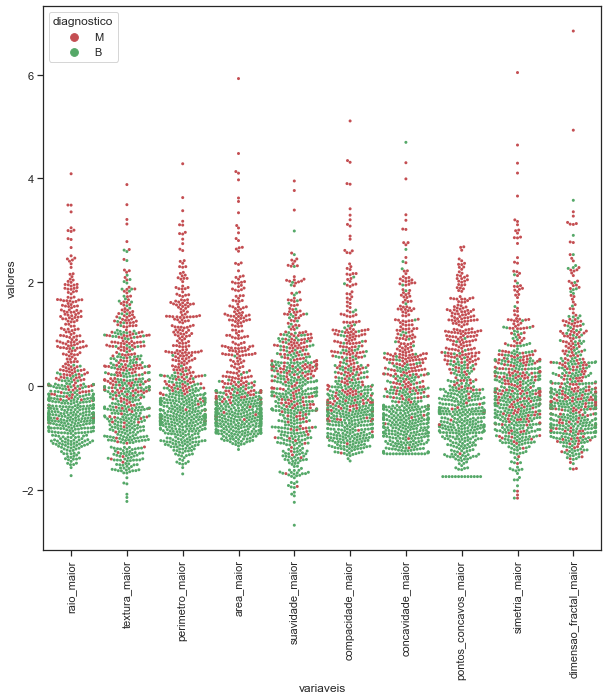

In [32]:
plot_swarm(df,20, 31, 'swarm_maior')

## Treinamento do Modelo

In [33]:
# X_train, X_test = train_test_split(df, test_size=0.20, random_state=13)
df_train = df.copy()

In [34]:
class RESULT(object):
    
    def __init__(self, model_name, y_pred, y_prob, y_test, tprs, aucs, thresholds):
        self.model_name = model_name
        self.y_pred = y_pred
        self.y_prob = y_prob        
        self.y_test = y_test
        self.tprs = tprs
        self.aucs = aucs
        self.thresholds = thresholds

In [35]:
models = {
    'Árvore de Decisão': DecisionTreeClassifier(),
    'Regressão Logística': LogisticRegression(),
    'K-Vizinhos mais Próximos': KNeighborsClassifier(n_neighbors=16),
    'Máquina de Vetores de Suporte': SVC(kernel='linear', probability=True)
}

In [36]:
n_folds = 10
results_exp1, models_pred_exp1 = perform_cv(df_train, models, n_folds)

Modelo: Árvore de Decisão

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Fold[6]

Fold[7]

Fold[8]

Fold[9]

Fold[10]

Acurácia: 0.9349736379613357

Auc: 0.930809658714819

Matriz de confusão: 
Previsto    B    M
Atual             
B         339   19
M          18  193

Relatório de Classificação: 
              precision    recall  f1-score   support

     Benigno       0.95      0.95      0.95       358
     Maligno       0.91      0.91      0.91       211

    accuracy                           0.93       569
   macro avg       0.93      0.93      0.93       569
weighted avg       0.94      0.93      0.94       569


########################################################

Modelo: Regressão Logística

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Fold[6]

Fold[7]

Fold[8]

Fold[9]

Fold[10]

Acurácia: 0.9472759226713533

Auc: 0.9452042936288089

Matriz de confusão: 
Previsto    B    M
Atual             
B         344   17
M          13  195

Relatório de Classificação: 
             

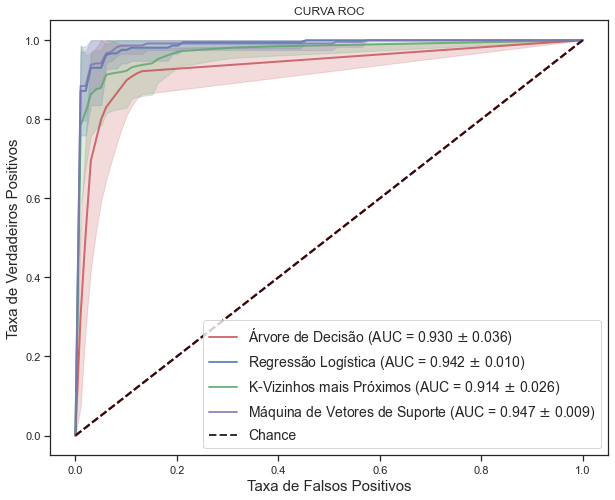

In [37]:
plot_roc_curve(results_exp1, 'roc_curve_unbalanced')

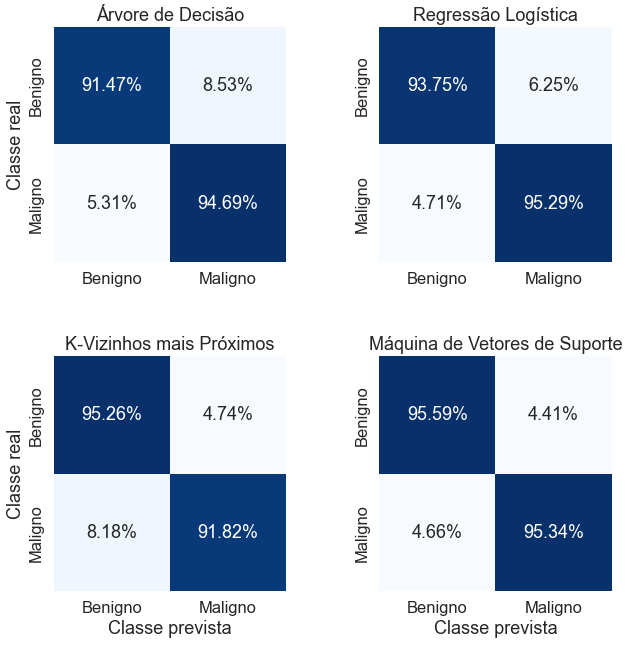

In [38]:
plot_confusion_matrix(results_exp1, ['Benigno', 'Maligno'], 'confusion_matrix')

<h6>Utilizando Árvore de Decisão com seleção de características</h6>

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

clf = SelectFromModel(DecisionTreeClassifier())
clf.fit(X, y)

SelectFromModel(estimator=DecisionTreeClassifier())

In [128]:
features = clf.get_support()

x_cols = X.columns.values[features == True]
x_cols = np.append(x_cols, 'diagnostico')

In [129]:
newDf = df[x_cols]
newDf.head()

raio_maior  textura_maior  pontos_concavos_maior diagnostico
0       25.38          17.33                 0.2654           M
1       24.99          23.41                 0.1860           M
2       23.57          25.53                 0.2430           M
3       14.91          26.50                 0.2575           M
4       22.54          16.67                 0.1625           M

In [130]:
models2 = {
    'Árvore de Decisão': DecisionTreeClassifier()
}

In [131]:
n_folds = 10
results_exp2, models_pred_exp2 = perform_cv(newDf, models2, n_folds)

Modelo: Árvore de Decisão

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Fold[6]

Fold[7]

Fold[8]

Fold[9]

Fold[10]

Acurácia: 0.945518453427065

Auc: 0.9437371553633864

Matriz de confusão: 
Previsto    B    M
Atual             
B         344   18
M          13  194

Relatório de Classificação: 
              precision    recall  f1-score   support

     Benigno       0.96      0.95      0.96       362
     Maligno       0.92      0.94      0.93       207

    accuracy                           0.95       569
   macro avg       0.94      0.94      0.94       569
weighted avg       0.95      0.95      0.95       569


########################################################



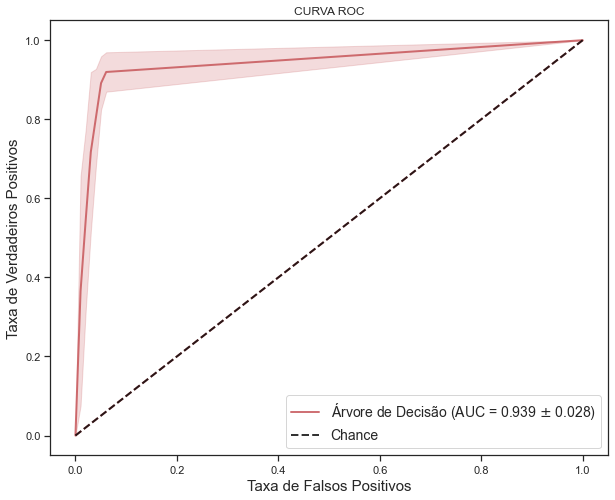

In [132]:
plot_roc_curve(results_exp2, 'roc_curve_unbalanced')

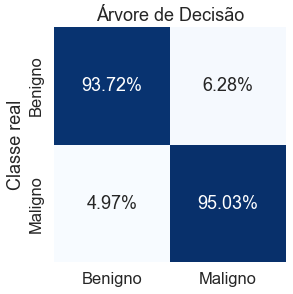

In [133]:
plot_confusion_matrix(results_exp2, ['Benigno', 'Maligno'], 'confusion_matrix')